# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Evening IEQ Measurements
Now that we have parsed the beacon data into time periods corresponding to when participants were asleep, it would be interesting to analyze what concentrations are being experienced during the evening.

## Package Import

In [3]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Data Import

## Beacon Data
We are only concerned with the beacon data when participants are asleep since that is the only time we can be sure participants are home in their bedrooms.

In [4]:
beacon = pd.read_csv('../data/processed/bpeace2-beacon-fb_and_gps_restricted.csv',
                    index_col=0,parse_dates=[0,-1,-2],infer_datetime_format=True)
beacon.head()

,Lat,Long,Alt,Accuracy,TVOC,eCO2,Lux,Visible,Infrared,NO2,...,PM_C_2p5,PM_C_4,PM_C_10,z,Beacon,Beiwe,Fitbit,REDCap,start_time,end_time
2020-08-10 05:10:00,30.58838,-97.42591,113.98145,5.29684,185.50,750.25,2.04,1.0,0.0,288.95,...,6.748117,10.714056,11.507244,1.441551,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:15:00,NaN,NaN,NaN,NaN,166.08,706.48,2.04,1.0,0.0,277.12,...,6.515844,10.288899,11.043510,1.468756,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:20:00,NaN,NaN,NaN,NaN,151.40,666.48,2.04,1.0,0.0,277.44,...,6.215933,9.795078,10.510907,1.492578,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:25:00,NaN,NaN,NaN,NaN,158.84,686.92,2.04,1.0,0.0,282.44,...,6.486098,10.357869,11.132223,1.457762,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:30:00,NaN,NaN,NaN,NaN,146.15,669.20,2.04,1.0,0.0,272.80,...,6.721101,10.739605,11.543306,1.430890,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30


## Participant Information
We need the participant beacon, beiwe, and fitbit IDs so we can cross-reference the various pieces of information.

In [97]:
# getting pt names
names = pd.read_excel('../data/raw/bpeace2/admin/id_crossover.xlsx',sheet_name='all')
names = names[['Beiwe ID','First','Last']]
# getting beacon only pts with names
info = pd.read_excel('../data/raw/bpeace2/admin/id_crossover.xlsx',sheet_name='beacon')
info = info[['REDCap','Beiwe','Beacon','Lat','Long']] # keep their address locations
info = info.merge(left_on='Beiwe',right=names,right_on='Beiwe ID')
info.head()

,REDCap,Beiwe,Beacon,Lat,Long,Beiwe ID,First,Last
0,10,kyj367pi,1,30.312614,-97.732338,kyj367pi,Angela,Gordillo
1,55,745vq78e,5,30.288012,-97.751201,745vq78e,Olivia,Li
2,61,itmylz3g,6,29.855371,-95.741200,itmylz3g,Rianna,Mendez
3,0,zdpffrox,7,30.326815,-97.744665,zdpffrox,Hagen,Fritz
4,43,xlw5ntd5,10,30.351693,-97.614524,xlw5ntd5,Katherine,Mai


## Fitbit Data
We will need some information from each of the participants that Fitbit logs like body weight.

In [98]:
daily = pd.read_csv('../data/processed/bpeace2-fitbit-daily.csv',
                   index_col=0,parse_dates=True,infer_datetime_format=True)
daily.head()

,activities_calories,activities_caloriesBMR,activities_steps,activities_distance,activities_minutesSedentary,activities_minutesLightlyActive,activities_minutesFairlyActive,activities_minutesVeryActive,activities_activityCalories,body_bmi,body_fat,body_weight,foods_log_caloriesIn,foods_log_water,beiwe
date,,,,,,,,,,,,,,,
2020-05-13,2781.0,1876.0,9207,4.396294,1241,70,118,11,1097.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-14,3727.0,1876.0,15207,7.261114,614,263,134,23,2234.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-15,3909.0,1876.0,14556,8.028501,577,205,57,108,2381.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-16,3927.0,1876.0,18453,8.748670,760,176,24,151,2364.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-17,4180.0,1876.0,15425,7.973149,605,207,50,131,2652.0,23.754,0.0,180.0,0.0,0.0,hfttkth7


# Ventilation based on constant CO2 concentration
We can estimate the ventilation rate of the participants' bedrooms based on a constant CO2 concentration:

$$
\lambda = \frac{E}{V \left(C - pC_0\right)}
$$

In our case we have to make quite a few assumptions:
- $E$: Emission rate of CO2 can be estimated for humans to be approximately $30 g/hr$. We can further refine this value by considering the height, weight, sex, and activity level of the participant - all information that we have access to. 
- $V$: Arguably the most difficult value to track down and the one that could affect the answer the most. We can assume a volume of each of the participants bedrooms, but there is the possiblility of refining this value by cross-referencing the participants' addresses with any known apartment complexes. From there, we can estimate the floor plan based on the number of roommates.
- $p$: Penetration factor of CO2 from outside into the indoor space - we can safely assume this to be 1.
- $C_0$: Outdoor concentration of CO2 - another safe assumption of 400 ppm. 

## Emission Rate
Based on an article that Sangeetha sent me, we can determine the emission rate of CO2 from the following equation:

$$
V_{CO_2} = (BMR)(M)(T/P)(0.000179)
$$

where:
- $V_{CO_2}$ is the volumetric emission rate of CO2 in L/s
- $BMR$ is the body mass ratio determined from Persily and De Jonge 2016
- $M$: Activity level in METs
- $T$ is the temperature in Kelvin
- $P$ is the pressure in kPa

### Body Mass Ratio
The body mass ratio is given by one of the two equations since our participants are in the age range of 18-30

$$
BMR_{male} = 0.063m + 2.896\\
BMR_{female} = 0.062m + 2.036
$$

where $m$ is the body mass in kilograms. We have the pariticpants body weights assuming they logged them into Fitbit. We can grab these data and put it alongside the participants beacon, beiwe, and fitbit IDs.

We will take the body weight for each participant, average it over the total amount of time logged (just in case they changed it which I doubt anyone did) and store that value in our ```ventilation_info``` dataframe.

In [99]:
weight_dict = {'Beiwe':[],'Mass':[]}
for pt in daily['beiwe'].unique():
    daily_pt = daily[daily['beiwe'] == pt]
    weight_dict['Beiwe'].append(pt)
    weight_dict['Mass'].append(np.nanmean(daily_pt['body_weight'])*0.453592) # convert to kg
    
mass_info = info.merge(left_on='Beiwe',right=pd.DataFrame(weight_dict),right_on='Beiwe')
mass_info.head()

,REDCap,Beiwe,Beacon,Lat,Long,Beiwe ID,First,Last,Mass
0,10,kyj367pi,1,30.312614,-97.732338,kyj367pi,Angela,Gordillo,52.014033
1,55,745vq78e,5,30.288012,-97.751201,745vq78e,Olivia,Li,53.523856
2,61,itmylz3g,6,29.855371,-95.741200,itmylz3g,Rianna,Mendez,63.502880
3,0,zdpffrox,7,30.326815,-97.744665,zdpffrox,Hagen,Fritz,74.842680
4,43,xlw5ntd5,10,30.351693,-97.614524,xlw5ntd5,Katherine,Mai,53.070264


In order to properly calculate the BMR of the participants, we need to know whether they are male or female. Participants had to mark whether or not they were male or female on the CRISIS baseline survey we sent via REDCap. 

In [106]:
# getting sex from baseline survey
crisis_baseline = pd.read_csv('../data/raw/bpeace2/surveys/CRISIS_E3_labels.csv',
                              usecols=[0,3],names=['REDCap','Sex'],header=0)
sex_info = mass_info.merge(left_on='REDCap',right=crisis_baseline,right_on='REDCap',how='outer')
sex_info.dropna(subset=['Beacon'],axis=0,inplace=True)
# adding sex manually
sex_info.iloc[3,-1] = 'Male' # Hagen Fritz
sex_info.iloc[4,-1] = 'Female' # Katherine Mai
sex_info.iloc[8,-1] = 'Female' # Elizabeth Avalos
sex_info.head()

,REDCap,Beiwe,Beacon,Lat,Long,Beiwe ID,First,Last,Mass,Sex
0,10,kyj367pi,1.0,30.312614,-97.732338,kyj367pi,Angela,Gordillo,52.014033,Female
1,55,745vq78e,5.0,30.288012,-97.751201,745vq78e,Olivia,Li,53.523856,Female
2,61,itmylz3g,6.0,29.855371,-95.741200,itmylz3g,Rianna,Mendez,63.502880,Female
3,0,zdpffrox,7.0,30.326815,-97.744665,zdpffrox,Hagen,Fritz,74.842680,Male
4,43,xlw5ntd5,10.0,30.351693,-97.614524,xlw5ntd5,Katherine,Mai,53.070264,Female


Now we calculate the BMR based on the mass and sex of the participants

In [109]:
def get_BMR(sex, mass):
    '''
    Calculates the BMR based on mass assuming an age range between 18 and 30
    
    Inputs:
    - sex: string in ['Male','Female']
    - mass: double of the mass in kg
    
    Returns BMR from Persily and De Jong 2016
    '''
    if sex.lower() == 'male':
        return 0.063*mass + 2.896
    elif sex.lower() == 'female':
        return 0.062*mass + 2.036
    else:
        return 0

In [144]:
sex_info['BMR'] = sex_info.apply(lambda row: get_BMR(row['Sex'],row['Mass']),axis=1)
pt_info = sex_info.set_index('Beiwe')
pt_info.head()

,REDCap,Beacon,Lat,Long,Beiwe ID,First,Last,Mass,Sex,BMR
Beiwe,,,,,,,,,,
kyj367pi,10,1.0,30.312614,-97.732338,kyj367pi,Angela,Gordillo,52.014033,Female,5.260870
745vq78e,55,5.0,30.288012,-97.751201,745vq78e,Olivia,Li,53.523856,Female,5.354479
itmylz3g,61,6.0,29.855371,-95.741200,itmylz3g,Rianna,Mendez,63.502880,Female,5.973179
zdpffrox,0,7.0,30.326815,-97.744665,zdpffrox,Hagen,Fritz,74.842680,Male,7.611089
xlw5ntd5,43,10.0,30.351693,-97.614524,xlw5ntd5,Katherine,Mai,53.070264,Female,5.326356


### Activity Level in METs
The Persily and De Jong 2016 article gives values for activity level in METs dependingon the activity. We can assume that our participants are asleep since we are only using data when Fitbit detects sleeping individuals. The MET value for a sleeping individual, from the article, is **0.95**.

### Temperature
The **temperature will vary depending on the night** that we choose to analyze and therefore will alter the emission rate of CO2. Thus we cannot establish a static emission rate.

### Pressure
The pressure will more or less remain constant since we are at the same altitude for the most part in Austin. The National Weather Service has a [station at the airport](https://w1.weather.gov/data/obhistory/KAUS.html) in Austin that reports the atmopsheric pressure is around **102.5 kPa**.

## Constant CO2
Now we need to find periods during the evening when the CO2 concentration is constant. We can do this by looking at the mean difference in CO2 concentration during a certain window. If the change is less than the sensor range ($\pm$30), we can then assume the concentration is stable.

We can also cross-reference with the temperature to make sure that the AC isn't jsut cycling on and off quickly keeping the CO2 within a tight window. 

### Processing Temperature
We want to make sure to use the temperature sensors from the DGS sensors rather than the CO2 sensor. There might be times when one of the temperature sensors is working or they are both operating. In the latter case, we want to average the values and then combine the temperature values into one column.

We will also need the temperature to better estimate the emission rate.

In [120]:
beacon['T'] = beacon[['T_CO','T_NO2']].mean(axis=1)
beacon['RH'] = beacon[['RH_CO','RH_NO2']].mean(axis=1)
beacon_co2 = beacon[['REDCap','Beiwe','Beacon','Fitbit','CO2','T','RH','start_time','end_time']]
beacon_co2.head()

,REDCap,Beiwe,Beacon,Fitbit,CO2,T,RH,start_time,end_time
2020-08-10 05:10:00,12,lkkjddam,21,25,1342.427700,24.0,33.15,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:15:00,12,lkkjddam,21,25,1326.702582,24.0,33.00,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:20:00,12,lkkjddam,21,25,1300.445127,24.0,33.00,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:25:00,12,lkkjddam,21,25,1262.876597,24.0,33.04,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:30:00,12,lkkjddam,21,25,1301.729658,24.0,33.00,2020-08-10 04:42:30,2020-08-10 12:35:30


In [121]:
def convert_ppm(concentration):
    '''
    Converts the ppm of CO2 to g/m3
    '''
    
    molar_mass_co2 = 44
    molar_volume_air = 24.5 
    return concentration / 10**6 * molar_mass_co2 / molar_volume_air * 1000

In [250]:
def get_constant_co2_periods(df,window_size=12,co2_threshold=10,t_threshold=0.2):
    '''
    Determines the number 
    '''
    period_dict = {}
    df = df.resample('5T').mean()
    df.fillna(0,inplace=True)
    
    df['dCO2'] = abs(df['CO2'] - df['CO2'].shift(1))
    df['dCO2_window'] = df['dCO2'].rolling(window_size,closed='left').mean()
    df['dCO2_window'] = df['dCO2_window'].shift(-1*(window_size-1))
    
    df['dT'] = abs(df['T'] - df['T'].shift(1))
    df['dT_window'] = df['dT'].rolling(window_size,closed='left').mean()
    df['dT_window'] = df['dT_window'].shift(-1*(window_size-1))
    
    period = 1
    for i in range(len(df)):
        if df['dCO2_window'][i] < co2_threshold and df['dT_window'][i] < t_threshold:
            period_dict[period] = df[i:i+window_size]
            period += 1
    
    return period_dict

In [251]:
def get_emission_rate(BMR, T):
    '''
    Calculates the CO2 emission rate
    
    Inputs:
    - BMR: double of body-mass-ratio
    - T: double of Temperature in Kelvin
    
    Returns CO2 emission rate in L/s
    '''
    
    # Assumed constants
    M = 0.95 #METs
    P = 102.5 #kPa
    
    return BMR * M * (T / P) * 0.000179

In [257]:
emission_df = pd.DataFrame()
for pt in beacon_co2['Beiwe'].unique():
    
    pt_dict = {'Beiwe':[],'Start':[],'End':[],'Avg_CO2':[],'dCO2':[],'Avg_T':[],'dT':[],'E':[]}
    
    beacon_pt = beacon_co2[beacon_co2['Beiwe'] == pt]
    
    for start, end in zip(beacon_pt['start_time'].unique(),beacon_pt['end_time'].unique()):
        beacon_pt_night = beacon_pt[start:end] # iaq data during sleep
        if len(beacon_pt_night) > 12:
            constant_periods = get_constant_co2_periods(beacon_pt_night[['CO2','T','RH']],window_size=24)
            for period in constant_periods.keys():
                T = np.mean(constant_periods[period]['T'])
                concentration = np.mean(constant_periods[period]['CO2'])
                if concentration > 400:
                    E = get_emission_rate(pt_info.loc[pt,'BMR'],T+273)
                    pt_dict['Beiwe'].append(pt)
                    pt_dict['Start'].append(start)
                    pt_dict['End'].append(end)
                    pt_dict['Avg_T'].append(T)
                    pt_dict['dT'].append(np.mean(abs(constant_periods[period]['T'] - constant_periods[period]['T'].shift(1))))
                    pt_dict['Avg_CO2'].append(concentration)
                    pt_dict['dCO2'].append(np.mean(abs(constant_periods[period]['CO2'] - constant_periods[period]['CO2'].shift(1))))
                    pt_dict['E'].append(E)
                
    pt_df = pd.DataFrame(pt_dict)
    emission_df = emission_df.append(pt_df)
                

In [258]:
emission_df

,Beiwe,Start,End,Avg_CO2,dCO2,Avg_T,dT,E
0,lkkjddam,2020-08-21 03:02:30,2020-08-21 11:30:00,1078.040512,8.941249,26.500000,0.130435,0.003799
1,lkkjddam,2020-08-21 03:02:30,2020-08-21 11:30:00,1079.606943,8.686468,26.541667,0.130435,0.003799
2,lkkjddam,2020-08-21 03:02:30,2020-08-21 11:30:00,1080.794088,8.417760,26.583333,0.130435,0.003800
3,lkkjddam,2020-08-21 03:02:30,2020-08-21 11:30:00,1081.979480,8.605416,26.625000,0.130435,0.003800
4,lkkjddam,2020-08-21 03:02:30,2020-08-21 11:30:00,1083.629814,8.775572,26.666667,0.108696,0.003801
...,...,...,...,...,...,...,...,...
32,9xmhtq74,2020-07-01 22:41:30,2020-07-02 06:02:30,1127.403130,7.734254,28.786667,0.106957,0.003061
33,9xmhtq74,2020-07-01 22:41:30,2020-07-02 06:02:30,1126.191126,7.768879,28.745000,0.121739,0.003061
34,9xmhtq74,2020-07-01 22:41:30,2020-07-02 06:02:30,1125.372044,7.562292,28.703333,0.121739,0.003060
35,9xmhtq74,2020-07-01 22:41:30,2020-07-02 06:02:30,1124.253177,7.643068,28.661667,0.121739,0.003060


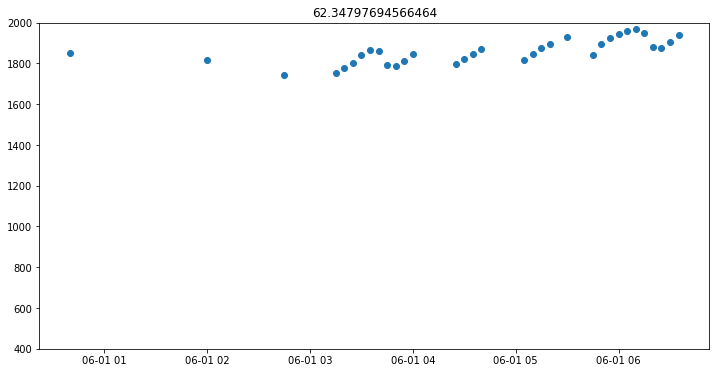

In [30]:
for pt in ['zdpffrox']:#beacon['Beiwe'].unique():
    beacon_pt = beacon_co2[beacon_co2['Beiwe'] == pt]
    for start, end in zip(beacon_pt['start_time'].unique(),beacon_pt['end_time'].unique()):
        beacon_pt_night = beacon_pt[start:end] # iaq data during sleep
        if len(beacon_pt_night) > 2:
            T_dict, CO2_dict = get_constant_co2_periods(beacon_pt_night[['CO2','T','RH']])
            co2_df = beacon_pt_night[['CO2']]
            co2_df = co2_df.resample('5T').mean()
            co2_df.fillna(0,inplace=True)
            co2_df['change'] = abs(co2_df['CO2'] - co2_df['CO2'].shift(1))
            co2_df['window_avg'] = co2_df['change'].rolling(12,closed='left').mean()
            co2_df['window_avg'] = co2_df['window_avg'].shift(-11)
            const_periods = {}
            period = 1
            for i in range(len(co2_df)):
                if co2_df['window_avg'][i] < 30:
                    const_periods[period] = co2_df['CO2'][i:i+11].values
                    period += 1

        if len(const_co2) > 1:
            fig, ax = plt.subplots(figsize=(12,6))
            ax.scatter(const_co2.index,const_co2['CO2'])
            ax.set_title(f'{std}')
            ax.set_ylim([400,2000])
            #ax.scatter(co2_df.index,co2_df['CO2'])

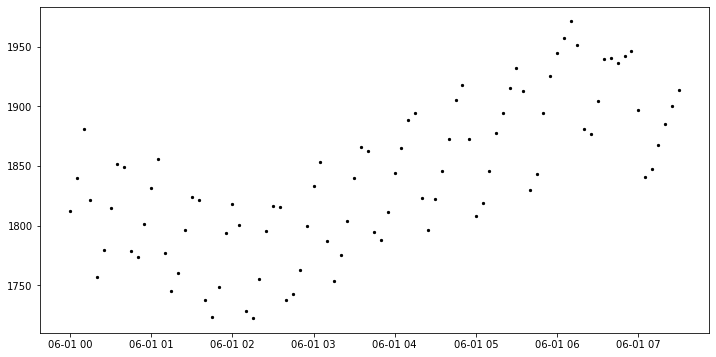

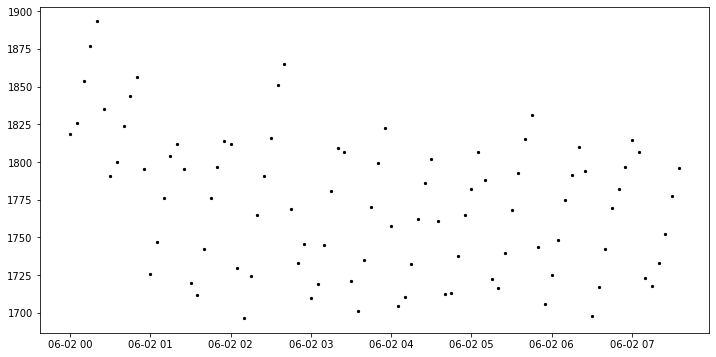

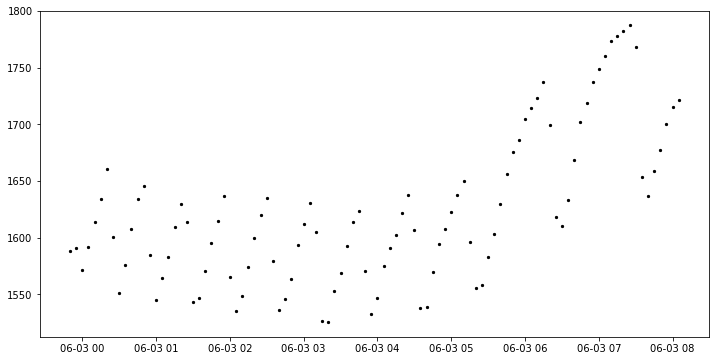

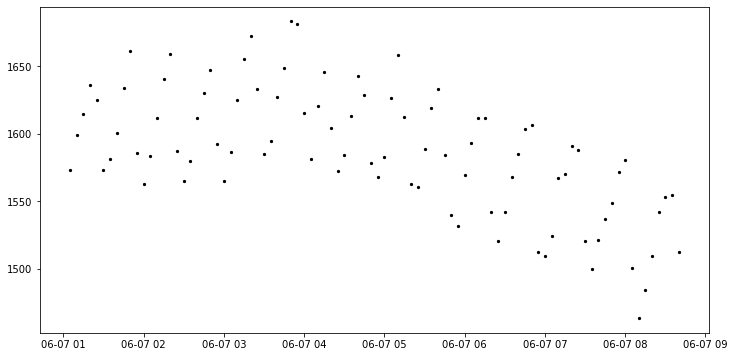

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 864x432 with 1 Axes>

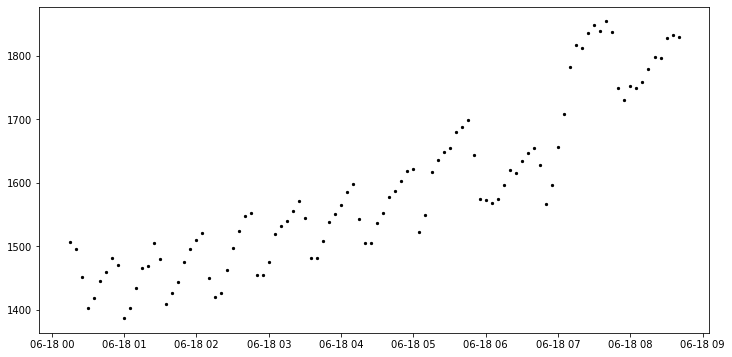

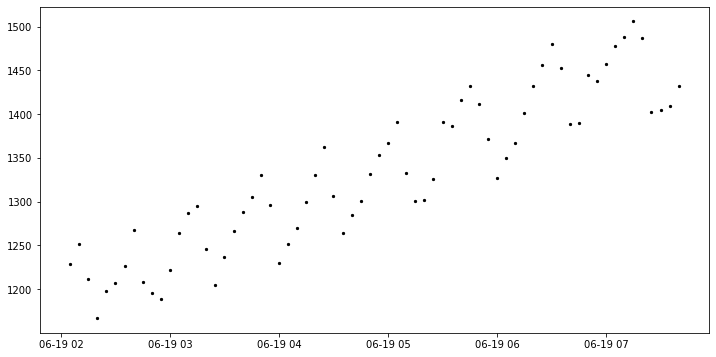

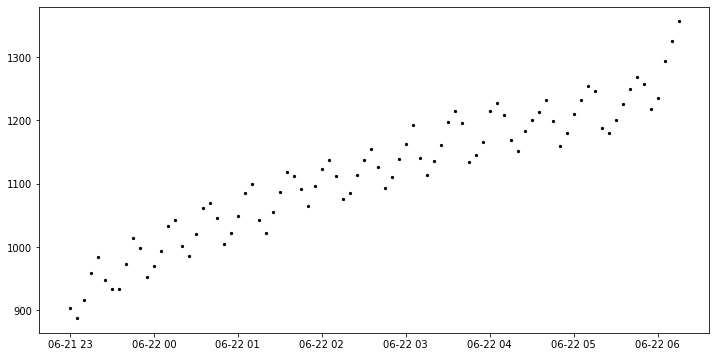

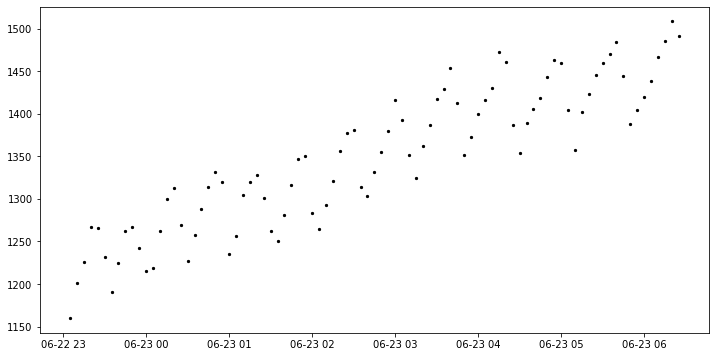

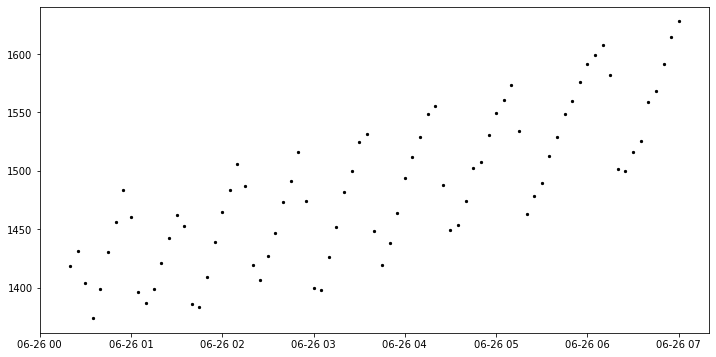

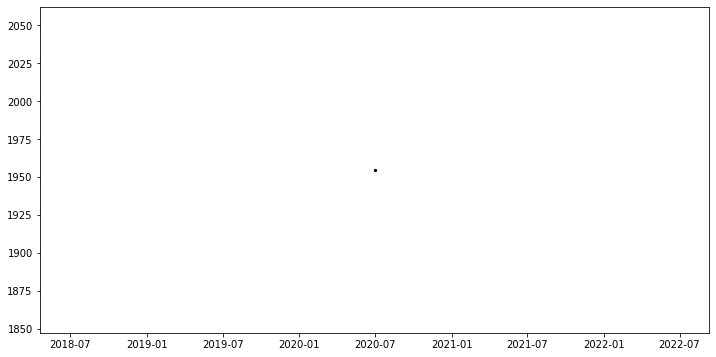

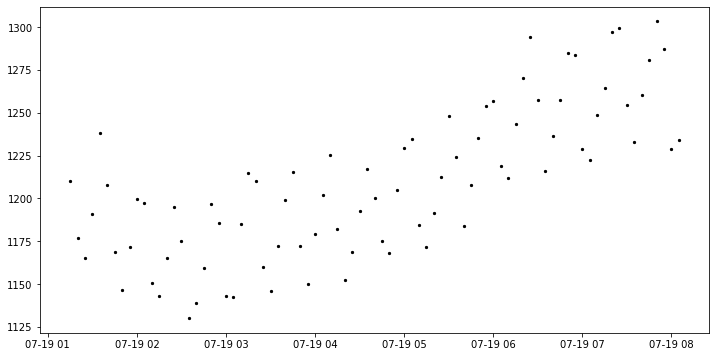

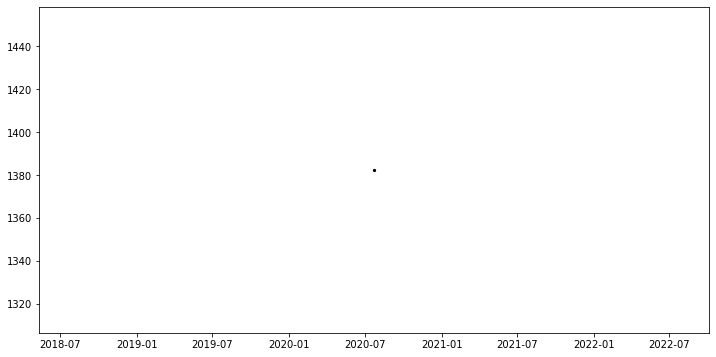

In [18]:
for pt in ['zdpffrox']:#beacon['Beiwe'].unique():
    beacon_pt = beacon[beacon['Beiwe'] == pt]
    for start, end in zip(beacon_pt['start_time'].unique(),beacon_pt['end_time'].unique()):
        #if (end - start).total_seconds()/3600 > 5: # sleeping longer than 5 hours
        beacon_pt_night = beacon_pt[start:end]
        fig, ax = plt.subplots(figsize=(12,6))
        ax.scatter(beacon_pt_night.index,beacon_pt_night['CO2'],color='black',s=5)
        plt.show()
        plt.close()

In [10]:
beacon_pt_night

,Lat,Long,Alt,Accuracy,TVOC,eCO2,Lux,Visible,Infrared,NO2,...,PM_C_2p5,PM_C_4,PM_C_10,z,Beacon,Beiwe,Fitbit,REDCap,start_time,end_time
2020-07-23 01:25:00,30.31899,-97.73973,197.0,2500.0,312.36,498.48,0.0,0.0,0.0,72.44,...,0.0,0.0,0.0,0.759453,7,zdpffrox,-1,0,2020-07-22 23:52:30,2020-07-23 07:35:30


In [39]:
base = datetime.today()
date_list = [base + timedelta(minutes=x) for x in range(360)]

In [40]:
co2 = list(np.zeros(60) +1000)
co2 += list(np.arange(1200,0,-20))
co2*=3
print(len(co2))
df = pd.DataFrame(data={'time':date_list,'CO2':co2})

360


In [41]:
df

,time,CO2
0,2020-11-19 14:17:51.997607,1000.0
1,2020-11-19 14:18:51.997607,1000.0
2,2020-11-19 14:19:51.997607,1000.0
3,2020-11-19 14:20:51.997607,1000.0
4,2020-11-19 14:21:51.997607,1000.0
...,...,...
355,2020-11-19 20:12:51.997607,100.0
356,2020-11-19 20:13:51.997607,80.0
357,2020-11-19 20:14:51.997607,60.0
358,2020-11-19 20:15:51.997607,40.0


In [43]:
df2 = pd.DataFrame(data={'time':[base + timedelta(minutes=x) for x in range(180)],'CO2':list(np.zeros(60) +1000)*3})

In [47]:
df2 = df[df['CO2'] == 1000]

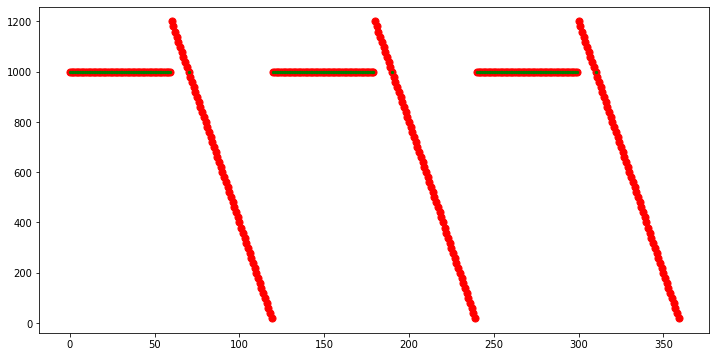

In [52]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df.index,df['CO2'],s=50,color='red')
ax.scatter(df2.index,df2['CO2'],s=5,color='green')